# Forecasting the average number of business visitors in New Zealand

This project aims to predict the average number of business visitors in New Zealand using two methods: Persistence forecast model and ARIMA Model. A successful model for predicting visitor numbers can provide some meaningful insights for the government in terms of visa policy and socioeconomic status. Relevant businesses can also take full advantage of the model and build better industry applications. To analyze the dataset and build a prediction model, Python was used throughout the whole process. The complete code can be found [here](https://github.com/Erica-Tan/NZVistors-TimeSeries).

In this project, we are interested to know:
* Which month had the largest number of business passengers in New Zealand? 
* What was the general trend of the monthly number of business visitors in New Zealand from 1998 to 2012?


The dataset is collected from the [Censusatschool website](http://new.censusatschool.org.nz/resource/time-series-data-sets-2012/) and it describes the monthly number of  visitors in New Zealand for the purpose of business from 1998 to 2012.  The units are an average passenger count and there are 161 observations. 



## 1. Loading and Handling Time Series in Pandas

Let's start by importing the required libraries.

In [1]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import boxcox
from math import sqrt
from math import log
from math import exp
import warnings

os.chdir("D:/Python/NZVistors Time Series")
warnings.filterwarnings("ignore")

Now, we can load the dataset and look at some initial rows and data types of the columns.

In [2]:
df_data = pd.read_csv("data/Average-number-of-visitors-in-New-Zealand-for-business.csv", header=0)

# format time attribute
dates = pd.to_datetime(df_data["Date"], format = '%YM%m')
df_data["Date"] = dates.apply(lambda x: x.strftime('%Y-%m-%d'))

df_data.to_csv("processed/dataset.csv", index=False)

series = pd.Series.from_csv("processed/dataset.csv", header=0)

print(series.head())

print('\n Data Types:')
print(series.dtypes)

Date
1998-09-01    6387
1998-10-01    6798
1998-11-01    7068
1998-12-01    5682
1999-01-01    5454
Name: Business, dtype: int64

 Data Types:
int64


The code below will first split the original dataset into two, one for model development (train.csv) and the other for test the final model(test.csv). This final year of data will be used to test the final model.

In [3]:
# create train.csv and test.csv
split_point = len(series) - 5
train, test = series[0:split_point], series[split_point:]
print('Train %d, Test %d' % (len(train), len(test)))
train.to_csv('processed/train.csv')
test.to_csv('processed/test.csv')

Train 160, Test 5


The below summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [4]:
print(train.describe())

count      160.000000
mean      7645.325000
std       1081.526673
min       5454.000000
25%       6906.250000
50%       7603.500000
75%       8300.250000
max      10506.000000
Name: Business, dtype: float64


## 2. Visualizing Time Series Data


### Line plot

The data was plotted as a time series with the yesr along the x-axis and number figures on the y-axis.

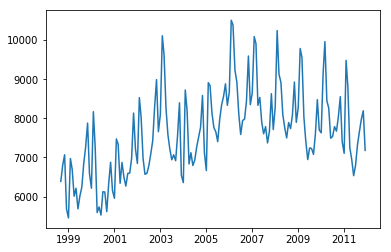

In [5]:
plt.plot(train)
plt.show()

It is clearly evident that there is a clear trend in the data along with some seasonal variations. 

This may suggest that the time series is not stationary and will require differencing to make it stationary. 

### Autocorrelation plot
Let's take a quick look at an autocorrelation plot of the time series.

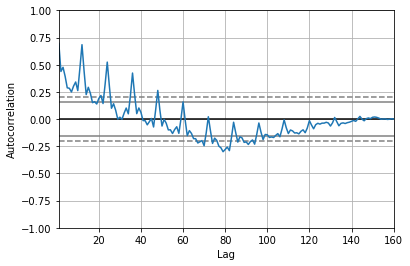

In [6]:
autocorrelation_plot(train)
plt.show()

The resulting plot shows lag along the x-axis and the correlation on the y-axis. Dotted lines are provided that indicate any correlation values above those lines are statistically significant.

We can see strong positive correlation with the first few lags and the wave cycles seen in the above plot are a strong sign of seasonality in the dataset.

Also, the time series does not shows a strong temporal dependence that decays linearly or in a similar pattern, which indicates that this time series is not a Random Walk.

### Density plot

Another important visualization is of the distribution of observations themselves. This plot can provide a clearer summary of the distribution.

The plot below shows a distribution that looks strongly Gaussian. 

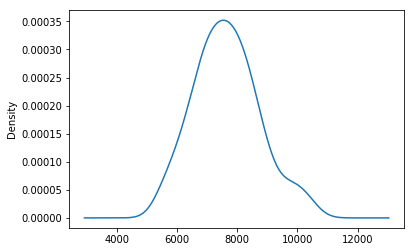

In [7]:
train.plot(kind='kde')
plt.show()

### Box and Whisker Plots

We can group the monthly data by year and get an idea of the spread of observations for each year and how this may be changing.

The first year (1998) only contains 4 months and may not be a useful comparison with the other 12 months of observations in the other years. Therefore, only data between 1998 and 2011 was plotted.

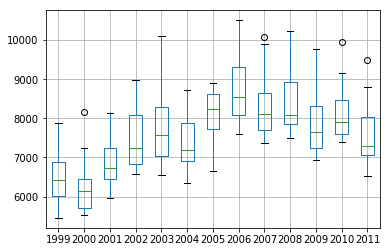

In [8]:
groups = train['1999':'2011'].groupby(pd.TimeGrouper('A'))
years = pd.DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
plt.show()

The observations suggest that the median values for each year show a trend that may not be linear, and the spread values are differ and not consistently over time.

### Decomposition plot 

Here we can see an overview of the data with different compositions.

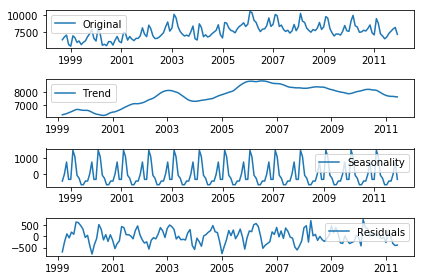

In [9]:
decomposition = seasonal_decompose(train)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 3. Baseline model

A baseline in forecast performance can provide a point of comparison. If a model achieves performance at or below the baseline, the technique should be fixed or abandoned.

Baseline model:
Test RMSE: 1059.834


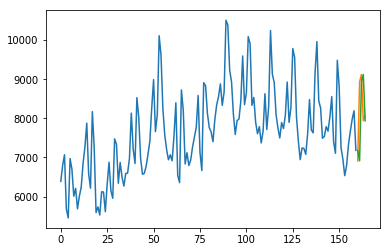

In [10]:
# Baseline model
def baseline_model(train, test):
        # walk-forward validation
        history = [x for x in train]
        predictions = list()
        for i in range(len(test)):
            # predict
            yhat = history[-1]
            predictions.append(yhat)
            # observation
            obs = test[i]
            history.append(obs)
        # report performance   
        rmse = sqrt(mean_squared_error(test, predictions))
        return rmse, predictions

# load and prepare datasets
train = pd.Series.from_csv('processed/train.csv')
test = pd.Series.from_csv('processed/test.csv')
# prepare data
X = train.values.astype('float32')
y = test.values.astype('float32')
# fit model
rmse, predictions = baseline_model(X, y)

print('Baseline model:')
print('Test RMSE: %.3f' % rmse)

# plot predictions and expected results
plt.plot(X)
plt.plot([None for i in X] + [x for x in y])
plt.plot([None for i in X] + [x for x in predictions])
plt.show()

From the plot of the persistence model predictions, it is clear that the model is 1-step behind reality. 

## 4. Forecasting a Time Series - ARIMA Model

Before building the model, we will convert the dataset to float32 in case the loaded data still has some String or Integer data types and split the train dataset into train and validation sets.

In [11]:
# load and prepare datasets
train = pd.Series.from_csv('processed/train.csv')
# prepare data
# split into train and validation sets
X = train.values.astype('float32')
train, validation = X[0:-12], X[-12:]

df_train = pd.Series(train)

### 4.1 Manually Configured ARIMA

First, we should check stationarity by using rolling statistics plots and Dickey-Fuller Test

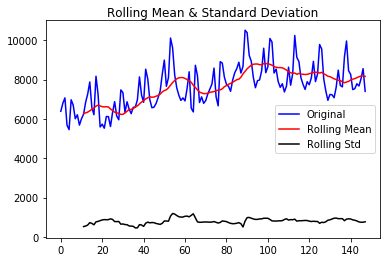

Results of Dickey-Fuller Test:
Test Statistic                  -1.580929
p-value                          0.493166
#Lags Used                      14.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64


In [12]:
# check if it is stationary
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_train)

Though the variation in standard deviation is small, mean is clearly varying with time. This time series is not a stationary series.

In termd of Dickey-Fuller test, the null hypothesis of the test is that the time series is not stationary. The alternate hypothesisis is that the time series is stationary.

The test statistic of -1.58 is bigger than the critical value at 5% of -2.893, mesning that we can accept the null hypothesis that the time series is non-stationary and does have time-dependent structure.

Next, I will use differencing to make this time series towards stationarity.

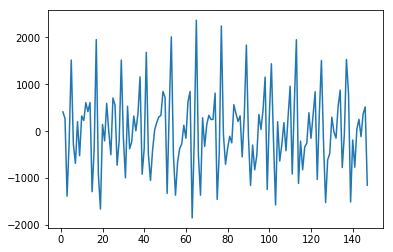

In [13]:
ts_diff = df_train - df_train.shift()

plt.plot(ts_diff)
plt.show()

Let's check the stationality again.

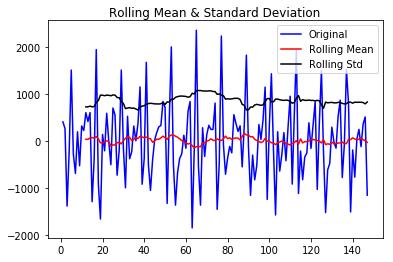

Results of Dickey-Fuller Test:
Test Statistic                  -3.614792
p-value                          0.005484
#Lags Used                      13.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64


In [14]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 1% critical value, thus the time series is stationary with 99% confidence. 

This suggests that one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1.


The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

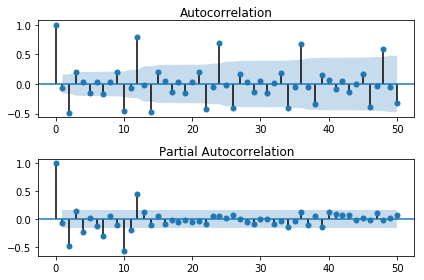

In [15]:
plt.figure()
plt.subplot(211)
# plot ACF
plot_acf(ts_diff, lags=50, ax=plt.gca())
plt.subplot(212)
# plot PACF
plot_pacf(ts_diff, lags=50, ax=plt.gca())
plt.tight_layout()
plt.show()

In this plot, the two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values. We can see that the values of p and q are both about 3 or 4.

This quick analysis suggests an ARIMA(3,1,3) on the raw data may be a good starting point.

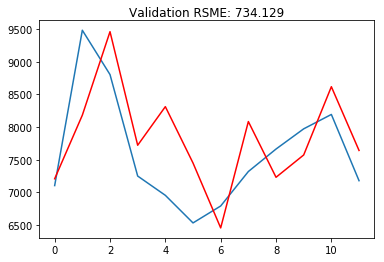

In [16]:
# ARIMA model
# an ARIMA model for a given order (p,d,q)
def fit_arima_model(train, test,  arima_order):
    # walk forward over time steps in test
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		output = model_fit.forecast()
		yhat = output[0][0]
		predictions.append(yhat)
		obs = test[t]
		history.append(obs)
		#print('predicted=%f, expected=%f' % (yhat, obs))
	# report performance
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse, predictions

rmse, predictions = fit_arima_model(train, validation, (3, 1, 3))

# plot
plt.plot(validation)
plt.plot(predictions, color='red')
plt.title('Validation RSME: %.3f'% rmse)
plt.show()

### 4.2 Using a grid search of ARIMA to find an optimized model.

We can automate the process of training and evaluating ARIMA models on different combinations of model hyperparameters using Grid Search, and then print the RMSE for each. I will also use walk-forward validation, which provids a much more robust estimation of how the chosen modeling method and parameters will perform.

In [17]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
	best_score, best_cfg = float("inf"), None
	# Iterate ARIMA Parameters
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse, predictions = fit_arima_model(train, test, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 4)
d_values = range(1, 3)
q_values = range(0, 4)
evaluate_models(train, validation, p_values, d_values, q_values)

ARIMA(0, 1, 0) RMSE=938.624
ARIMA(0, 1, 1) RMSE=938.551
ARIMA(0, 1, 2) RMSE=692.282
ARIMA(0, 1, 3) RMSE=699.297
ARIMA(0, 2, 0) RMSE=1348.067
ARIMA(0, 2, 1) RMSE=947.496
ARIMA(1, 1, 0) RMSE=941.656
ARIMA(1, 1, 1) RMSE=863.493
ARIMA(1, 1, 2) RMSE=698.798
ARIMA(1, 1, 3) RMSE=735.025
ARIMA(1, 2, 0) RMSE=1315.425
ARIMA(1, 2, 1) RMSE=950.349
ARIMA(1, 2, 3) RMSE=661.548
ARIMA(2, 1, 0) RMSE=799.053
ARIMA(2, 1, 1) RMSE=773.777
ARIMA(2, 1, 2) RMSE=699.472
ARIMA(2, 1, 3) RMSE=729.204
ARIMA(2, 2, 0) RMSE=990.826
ARIMA(2, 2, 1) RMSE=806.416
ARIMA(2, 2, 2) RMSE=779.619
ARIMA(3, 1, 0) RMSE=802.198
ARIMA(3, 1, 1) RMSE=770.024
ARIMA(3, 1, 2) RMSE=745.802
ARIMA(3, 1, 3) RMSE=734.129
ARIMA(3, 2, 0) RMSE=994.272
ARIMA(3, 2, 1) RMSE=810.282
ARIMA(3, 2, 2) RMSE=776.523
Best ARIMA(1, 2, 3) RMSE=661.548


The best parameters of ARIMA(1, 2, 3) are reported at the end of the run with a RMSE of 661.548.

Next, I will use the best parameters to make a ARIMA model.

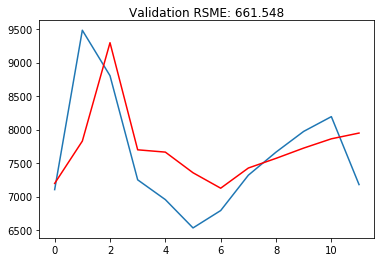

In [18]:
rmse, predictions = fit_arima_model(train, validation, (1, 2, 3))

# plot
plt.plot(validation)
plt.plot(predictions, color='red')
plt.title('Validation RSME: %.3f'% rmse)
plt.show()

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). 
We can see the values show some trend and are in the correct scale.

### 4.3 Analysis of forecast residual errors to evaluate any bias in the model.

A good final check of a model is to review residual forecast errors.

In [19]:
# calculate residuals
residuals = [validation[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

#### Residual Line Plot

The first plot is to look at the residual forecast errors over time as a line plot.

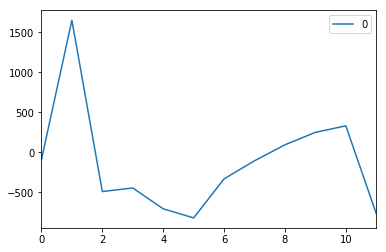

In [20]:
# plot residuals
residuals.plot()
plt.show()

#### Residual Summary Statistics

We can see how the errors are spread around zero from summary statistics. This includes the mean and standard deviation of the distribution, as well as percentiles and the minimum and maximum errors observed.

It is useful to know about a bias in the forecasts as it can be directly corrected in forecasts prior to their use or evaluation.

In [21]:
# summary statistics
print(residuals.describe())

                 0
count    12.000000
mean   -120.534063
std     679.398196
min    -822.415102
25%    -546.184368
50%    -220.061490
75%     131.829193
max    1652.471940


The summary above shows a mean error value does not close to zero. It suggests that there may be some bias in the model. 

#### Residual Density Plots

Density Plots can be used to better understand the distribution of errors beyond summary statistics and discover skews in this distribution.

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

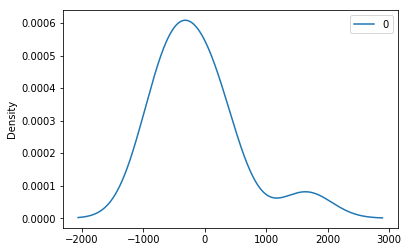

In [22]:
# density plot
residuals.plot(kind='kde')
plt.show()

The graphs suggest a Gaussian-like distribution with a longer right tail.There may be some bias in the model and we may be able to further improve the model by performing a bias correction. This could be done by adding the mean residual error to forecasts or performing a transform to the data prior to modeling, such as taking the log or square root.

### 4.4 Explore improvements to the model using power transforms

The Box-Cox transform is a method that is able to evaluate a suite of power transforms, including, but not limited to, log, square root, and reciprocal transforms of the data. 

The process involves first performimg a log transform of the history prior to fitting the ARIMA model, then inverting the transform on the prediction before storing it for later comparison with the expected values. 

By convention, lambda values are evaluated between -5 and 5. However, the boxcox() function can fail. it appears to be signaled by a returned lambda value of less than -5. 

A check is added for a lambda value less than -5, and if this the case, a lambda value of 1 is assumed and the raw history is used to fit the model. A lambda value of 1 is the same as “no-transform” and therefore the inverse transform has no effect.

In [23]:
# Transform ARIMA model
# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# an transform ARIMA model for a given order (p,d,q)
def fit_transform_arima_model(train, test, arima_order):
	# walk-forward validation
	history = [x for x in train]
	predictions = list()
	for t in range(len(test)):
		# transform
		transformed, lam = boxcox(history)
		if lam < -5:
		    transformed, lam = history, 1		
		model = ARIMA(transformed, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		# invert transformed prediction
		yhat = boxcox_inverse(yhat, lam)
		predictions.append(yhat)
        # observation
		obs = test[t]
		history.append(obs)
		#print('predicted=%f, expected=%f' % (yhat, obs))
	# report performance   
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse, predictions

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
	best_score, best_cfg = float("inf"), None
	# Iterate ARIMA Parameters
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse, predictions = fit_transform_arima_model(train, test, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 4)
d_values = range(1, 3)
q_values = range(0, 4)
evaluate_models(train, validation, p_values, d_values, q_values)

ARIMA(0, 1, 0) RMSE=939.222
ARIMA(0, 1, 1) RMSE=932.077
ARIMA(0, 1, 2) RMSE=688.528
ARIMA(0, 1, 3) RMSE=692.617
ARIMA(0, 2, 0) RMSE=1462.105
ARIMA(0, 2, 1) RMSE=946.837
ARIMA(1, 1, 0) RMSE=940.539
ARIMA(1, 1, 1) RMSE=853.292
ARIMA(1, 1, 2) RMSE=692.288
ARIMA(1, 1, 3) RMSE=732.142
ARIMA(1, 2, 0) RMSE=1352.846
ARIMA(1, 2, 1) RMSE=948.100
ARIMA(2, 1, 0) RMSE=794.210
ARIMA(2, 1, 1) RMSE=769.038
ARIMA(2, 1, 2) RMSE=691.836
ARIMA(2, 1, 3) RMSE=719.143
ARIMA(2, 2, 0) RMSE=969.080
ARIMA(2, 2, 1) RMSE=800.819
ARIMA(2, 2, 2) RMSE=776.416
ARIMA(3, 1, 0) RMSE=795.998
ARIMA(3, 1, 1) RMSE=763.872
ARIMA(3, 1, 2) RMSE=733.751
ARIMA(3, 1, 3) RMSE=732.160
ARIMA(3, 2, 0) RMSE=970.757
ARIMA(3, 2, 1) RMSE=803.328
ARIMA(3, 2, 2) RMSE=762.576
Best ARIMA(0, 1, 2) RMSE=688.528


The best parameters of ARIMA(0, 1, 2) are reported at the end of the run with a RMSE of 688.528.

Next, I will use the best parameters to make a ARIMA model.

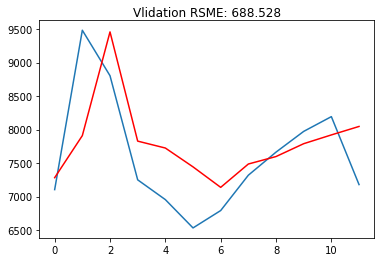

In [24]:
rmse, predictions = fit_transform_arima_model(train, validation, (0, 1, 2))
    
# plot
plt.plot(validation)
plt.plot(predictions, color='red')
plt.title('Vlidation RSME: %.3f'% rmse)
plt.show()

The final RMSE of the model on the transformed data was 688.528. This is a bigger error than the ARIMA model on untransformed data, but only slightly, and it may or may not be statistically different.


It is usually necessary to investigate the residual forecast errors on the model with Box-Cox transforms to see if there is a further bias.

                 0
count    12.000000
mean   -197.813420
std     688.825517
min    -910.145500
25%    -682.162363
50%    -261.824210
75%      95.286635
max    1570.749490


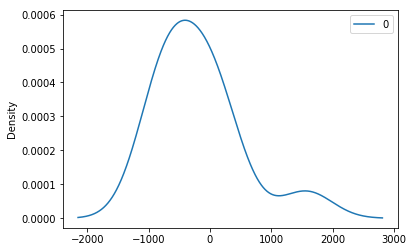

In [25]:
# calculate residuals
residuals = [validation[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

# summary statistics
print(residuals.describe())

# density plot
residuals.plot(kind='kde')
plt.show()

The summary and desity plot above shows the residual forecast errors on the model with Box-Cox transforms and without transforms are almost the same.

We will use this model without the Box-Cox transform as the final model.

## 5. Model Validation

After models have been developed and a final model selected, it must be finalized and  validated.

### Finalize Model

Finalizing the model involves fitting an ARIMA model on the entire dataset.

Once fit, the model can be saved to file for later use. Because the final model is not invertible when using parameters (1, 2, 3), we will use the second best parameters (0, 1, 2)

In [26]:
# Finalize Model
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
 
ARIMA.__getnewargs__ = __getnewargs__

# load data
train = pd.Series.from_csv('processed/train.csv')
# prepare data
X = train.values.astype('float32')
# fit model
model = ARIMA(X, order=(0, 1, 2))
model_fit = model.fit(disp=0)
# save model
model_fit.save('output/arima_model.pkl')

### Validate Model

In the first section, we saved the final 5 months of the original dataset in a separate file to validate the final model.

Now, the test.csv file can be loaded and used see how well our model really is on unseen data.

We will make predictions in a rolling-forecast manner. This means that we will step over lead times in the validation dataset and take the observations as an update to the history.

>Predicted=7112.632, Expected=6913
>Predicted=7556.622, Expected=8938
>Predicted=8946.633, Expected=9118
>Predicted=8133.078, Expected=7937
>Predicted=7846.360, Expected=8068
Test RMSE: 642.650


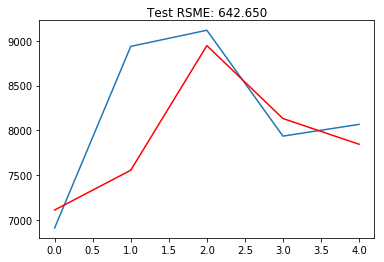

In [27]:
# load and prepare datasets
train = pd.Series.from_csv('processed/train.csv')
X = train.values.astype('float32')
history = [x for x in X]
test = pd.Series.from_csv('processed/test.csv')
y = test.values.astype('float32')

# load model
model_fit = ARIMAResults.load('output/arima_model.pkl')

# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# walk-forward validation
for i in range(1, len(y)):
    # make prediction
    model = ARIMA(history, order=(0, 1, 2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))

print('Test RMSE: %.3f' % rmse)

plt.plot(y)
plt.plot(predictions, color='red')
plt.title('Test RSME: %.3f'% rmse)
plt.show()

## 6. Conclusion

We may be able to further improve the model by using a statistical test to check if the difference in results between different models is statistically significant, displaying the confidence intervals for the predictions on the test dataset, or considering data Selection.